In [17]:
# If running on Colab, install dependencies
import sys, subprocess, os, torch
!pip -q install gensim spacy pandas scikit-learn matplotlib tqdm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
# Imports and paths
import pandas as pd
import numpy as np
import spacy
from collections import Counter, defaultdict
from pathlib import Path
import pickle

ROOT = Path().resolve().parent
DATA = ROOT / "notebooks" / "data"
EMB_OUT = DATA / "w2v_300d_embedding_matrix.npy"
VOCAB_OUT = DATA / "vocab.pkl"

train_df = pd.read_csv(DATA / "trec_train.csv")
val_df   = pd.read_csv(DATA / "trec_val.csv")
test_df  = pd.read_csv(DATA / "trec_test.csv")

print(train_df.shape, val_df.shape, test_df.shape)


(4362, 2) (1090, 2) (500, 2)


# From Part 1

In [20]:
# Load embedding and vocab
embedding_matrix = np.load(EMB_OUT)

with open(VOCAB_OUT, "rb") as f:
    vocab = pickle.load(f)
stoi = vocab['stoi']
itos = vocab['itos']

PAD_IDX, UNK_IDX = 0, 1
VOCAB_SIZE = len(itos)
EMBED_DIM = embedding_matrix.shape[1]

In [21]:
# Maps labels from string to index for modelling
label_map = {label: i for i, label in enumerate(sorted(train_df['label'].unique()))}

In [22]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

def tokenize(text):
    doc = nlp(text)
    return [t.text.lower() for t in doc if not t.is_space]

# Part 2

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config init
HIDDEN_DIM = 128
DROPOUT = 0.0
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 300
N_LAYERS = 1
PAD_IDX = 0
UNK_IDX = 1
OUTPUT_DIM = 6

In [24]:
# Utils Helper
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn # Import nn module

from torch.nn.utils.rnn import pack_padded_sequence
# RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, pad_idx, n_layers, embedding_matrix, aggregration_strat='last', dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(),freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(input_size=embedding_dim,hidden_size=hidden_dim,num_layers=n_layers,batch_first=True, dropout=dropout if n_layers > 1 else 0.0)

        self.embedding_dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.aggregation = aggregration_strat
        self.hidden_dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)

        lengths = (x != PAD_IDX).sum(dim=1).cpu()
        packed_seq = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_seq)

        # Sentence Aggregation
        if self.aggregation == 'last':
            last_hidden = hidden[-1]
        elif self.aggregation == 'mean':
            last_hidden = packed_output.mean(dim=1)
        elif self.aggregation == 'max':
            last_hidden = torch.max(packed_output,dim=1)

        # last_hidden = hidden[-1]

        last_hidden = self.hidden_dropout(last_hidden)
        logits = self.fc(last_hidden)
        return logits


class txtDataset(Dataset):
    def __init__(self, df, stoi,label_map):
        self.texts = df['text'].tolist()
        self.labels = df['label'].map(label_map).tolist()
        self.stoi = stoi

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = [self.stoi.get(token, UNK_IDX) for token in tokenize(text)]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    text,labels = zip(*batch)
    text_padding = pad_sequence(text,batch_first=True,padding_value=PAD_IDX)
    labels = torch.stack(labels)
    return text_padding,labels


# Training and Test Loop
def train_loop(train_dataloader,model,criterion,optimizer):
    model.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss, train_correct = 0,0
    for batch, (X,y) in enumerate (train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred,y)
        loss.backward()
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        optimizer.step()

    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test(test_dataloader,model,criterion):
    model.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    val_loss, val_correct = 0,0
    with torch.no_grad():
        for batch, (X,y) in enumerate (test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += criterion(pred,y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= num_batches
        val_correct /=size

    return val_loss, val_correct

# Model Training
def train(train_dataloader,val_dataloader,model,criterion,optimizer,epochs = EPOCHS, patience=5):
    train_acc_, val_acc_, train_loss_, val_loss_ = [], [], [], []
    best_val_acc = 0
    epochs_no_improve = 0

    for i in range(epochs):
        train_loss, train_acc = train_loop(train_dataloader,model,criterion,optimizer)
        val_loss, val_acc = test(val_dataloader,model,criterion)

        train_acc_.append(train_acc)
        val_acc_.append(val_acc)
        train_loss_.append(train_loss)
        val_loss_.append(val_loss)

        print(f"Epoch {i+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {i+1} epochs due to no improvement in validation accuracy.")
                break

    return train_acc_, val_acc_, train_loss_, val_loss_

# Plotting
import matplotlib.pyplot as plt
def plot(train_acc_,val_acc_,train_loss_,val_loss_):
    # Loss Plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_loss_)+1), train_loss_, label="Train Loss")
    plt.plot(range(1, len(val_loss_)+1), val_loss_, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_acc_)+1), train_acc_, label="Train Accuracy")
    plt.plot(range(1, len(val_acc_)+1), val_acc_, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.show()

Epoch 1/50 | Train Loss: 1.4363 | Train Acc: 0.3845 | Val Loss: 1.1152 | Val Acc: 0.5450
Epoch 2/50 | Train Loss: 0.8639 | Train Acc: 0.6829 | Val Loss: 0.7825 | Val Acc: 0.7165
Epoch 3/50 | Train Loss: 0.3933 | Train Acc: 0.8778 | Val Loss: 0.6149 | Val Acc: 0.8009
Epoch 4/50 | Train Loss: 0.2427 | Train Acc: 0.9262 | Val Loss: 0.5119 | Val Acc: 0.8505
Epoch 5/50 | Train Loss: 0.1178 | Train Acc: 0.9658 | Val Loss: 0.4793 | Val Acc: 0.8624
Epoch 6/50 | Train Loss: 0.0593 | Train Acc: 0.9860 | Val Loss: 0.5218 | Val Acc: 0.8514
Epoch 7/50 | Train Loss: 0.0311 | Train Acc: 0.9947 | Val Loss: 0.5615 | Val Acc: 0.8495
Epoch 8/50 | Train Loss: 0.0441 | Train Acc: 0.9917 | Val Loss: 0.5970 | Val Acc: 0.8486
Epoch 9/50 | Train Loss: 0.0552 | Train Acc: 0.9856 | Val Loss: 0.7214 | Val Acc: 0.8083
Epoch 10/50 | Train Loss: 0.0557 | Train Acc: 0.9844 | Val Loss: 0.6957 | Val Acc: 0.8294
Early stopping after 10 epochs due to no improvement in validation accuracy.


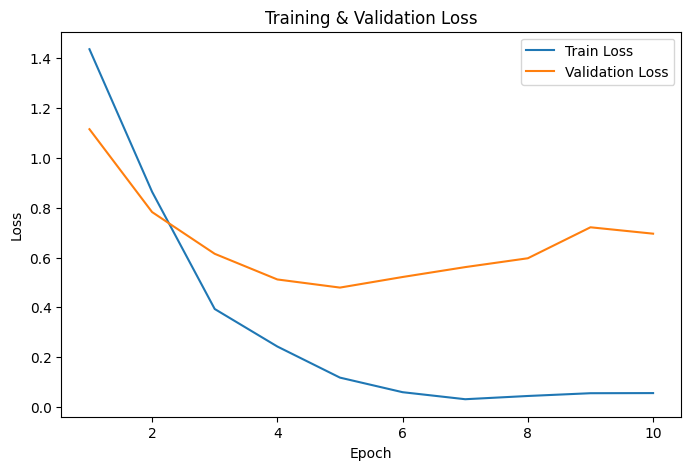

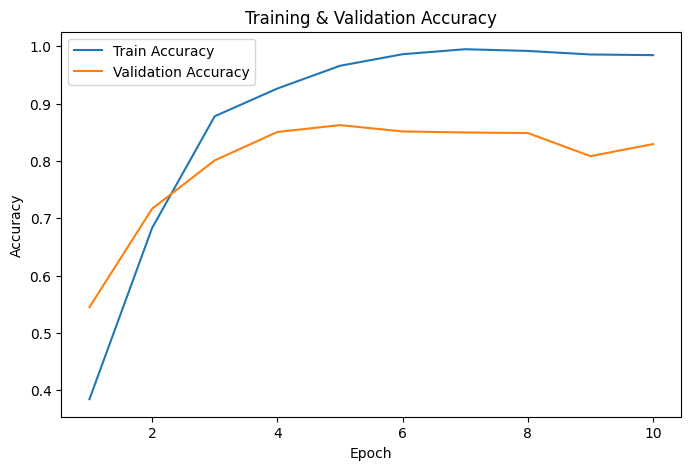

In [25]:
# Main
train_data = txtDataset(train_df,stoi,label_map)
val_data = txtDataset(val_df, stoi,label_map)
test_data = txtDataset(test_df, stoi,label_map)

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

model = RNNClassifier(EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,PAD_IDX,N_LAYERS,embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
train_acc_, val_acc_, train_loss_, val_loss_ = train(train_dataloader,val_dataloader,model,criterion,optimizer)
plot(train_acc_, val_acc_, train_loss_, val_loss_)